<a href="https://colab.research.google.com/github/mmender2/DataScience/blob/main/MMEmbed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Imports

In [ ]:
!pip install google-cloud-aiplatform --quiet

In [25]:
from google.colab import auth
auth.authenticate_user()

In [10]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.preprocessing import LabelEncoder
import random
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, LSTM, Bidirectional, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import os
from PIL import Image
import requests
import warnings
import re

# Functions and Data Processing

In [ ]:
data_path = '/content/drive/MyDrive/LicensePlate/states'
size = (512, 512)

# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=size):
    images = []
    for path in image_paths:
        # Load image and resize it to the target size
        img = load_img(path, target_size=target_size)
        # Convert image to array
        img_array = img_to_array(img)
        images.append(img_array)
    # Normalize the images to [0, 1] range and return
    return images / 255.0

# Function to extract labels from given image paths
def extract_labels_from_paths(paths):
    # Extracts the directory name as label from the path
    return [os.path.basename(os.path.dirname(path)) for path in paths]

# Function to create pairs of images
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = max(labels) + 1
    # Create a list of indices for each label
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for i in range(len(images)):
        positive_index = i
        # Choose a random index from a different class for negative pairing
        negative_index = np.random.choice(class_indices[(labels[i] + 1) % num_classes])

        # Positive pair and its label
        pairs += [[images[i], images[positive_index]]]
        pair_labels += [1]

        # Negative pair and its label
        pairs += [[images[i], images[negative_index]]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)

from sklearn.preprocessing import LabelEncoder

def create_metadata(data_path):
    image_paths = []
    labels = []

    # List all files in the data_path directory
    file_names = os.listdir(data_path)

    for file_name in file_names:
        # Check if the file is an image with .png extension
        if file_name.endswith('.png'):
            image_paths.append(os.path.join(data_path, file_name))

            # Assuming file_name is in the format 'state_name.png'
            # Extracting the state name as label by stripping '.png' from the end.
            labels.append(file_name[:-4])

    # Create a DataFrame with image paths and their corresponding labels
    meta_data = pd.DataFrame(
        {
            'image_paths': image_paths,
            'labels': labels
        }, dtype=object
    )
    return meta_data

# Create metadata for the images in the provided data path
data = create_metadata(data_path)
print(data.shape)

# Display a random sample of 5 rows from the metadata
data.sample(5)


In [ ]:
# Initialize TrOCR
url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
# Suppress specific warnings
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Initialize the MMOCR inferencer without KIE
infer = MMOCRInferencer(det='dbnetpp', rec='svtr-small')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/LicensePlate/fifth-composite-395916-8a836430659f.json"
# Initialize the Vision client
client = vision.ImageAnnotatorClient()

In [ ]:
import string
# Add lowercase letters to the set of characters and regenerate the mapping
all_characters = sorted(set(string.ascii_uppercase + string.ascii_lowercase + string.digits))

char_to_num = {char: i for i, char in enumerate(all_characters)}
num_to_char = {i: char for char, i in char_to_num.items()}

#num_to_char

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def data_generator(data_sample, char_to_num):
    pltI = []  # List to store preprocessed images
    edge = []  # List to store edge-detected images
    labels = []  # List to store the labels associated with each image

    for index, sample in enumerate(data_sample):
        # Extract image path and associated label from the sample
        image_path = sample['image_paths']
        label_text = sample['labels']

        # Read the image in grayscale mode and resize to (512, 512)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (512, 512))

        # Check if image reading was successful
        if image is None:
            print(f"Failed to read image at index {index} with path: {image_path}")
            continue

        # Apply morphological top-hat operation to emphasize light regions against a dark background
        structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        imgTopHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuringElement)

        # Apply morphological black-hat operation to emphasize dark regions against a light background
        imgBlackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuringElement)

        # Enhance the image by adding the result of the top-hat operation and subtracting the result of the black-hat operation
        imgGrayscalePlusTopHat = cv2.add(image, imgTopHat)
        image = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

        # Apply Gaussian blur to reduce image noise
        img_blurred = cv2.GaussianBlur(image, ksize=(5, 5), sigmaX=0)

        # Apply adaptive thresholding to binarize the image
        thresh_image = cv2.adaptiveThreshold(
            img_blurred,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            65,
            2
        )

        # Detect contours in the binarized image
        contours, _= cv2.findContours(
            thresh_image,
            mode=cv2.RETR_LIST,
            method=cv2.CHAIN_APPROX_SIMPLE
        )

        # Initialize a blank image to draw the contours
        temp_result = np.zeros((512, 512), dtype=np.uint8)

        # Draw the detected contours on the blank image
        cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=255, thickness=-1)

        # Invert the image (make black regions white and vice versa)
        inverted_temp_result = cv2.bitwise_not(temp_result)

        # Apply Canny edge detection on the inverted image
        edges = cv2.Canny(inverted_temp_result, 50, 150)

        # Store the preprocessed image, edge-detected image, and label into their respective lists
        pltI.append(inverted_temp_result)
        edge.append(edges)
        labels.append(label_text)

    # Return the lists containing preprocessed images, edge-detected images, and labels
    return pltI, edge, labels


In [ ]:
from sklearn.model_selection import train_test_split
from math import ceil

#dataSample = data.sample(n=len(data), random_state=42).reset_index(drop=True)
data_list = data[['image_paths', 'labels']].to_dict('records')

# Split the data_list into training and validation sets (e.g., 80% train, 20% validation)
train_data, val_data = train_test_split(data_list, test_size=0.4, random_state=42)

batch_size = 32
train_steps_per_epoch = len(train_data) // batch_size  # This will give 84
val_steps_per_epoch = len(val_data) // batch_size  # This will give 56

In [ ]:
# List of US States
us_states = [
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
    'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois',
    'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland',
    'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'montana',
    'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york',
    'north carolina', 'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
    'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah',
    'vermont', 'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming'
]

# Multimodel Embedding

---




In [ ]:
data_path = '/content/drive/MyDrive/LicensePlate/archive/data'
size = (512, 512)

# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=size):
    images = []
    for path in image_paths:
        # Load image and resize it to the target size
        img = load_img(path, target_size=target_size)
        # Convert image to array
        img_array = img_to_array(img)
        images.append(img_array)
    # Normalize the images to [0, 1] range and return
    return images / 255.0

# Function to extract labels from given image paths
def extract_labels_from_paths(paths):
    # Extracts the directory name as label from the path
    return [os.path.basename(os.path.dirname(path)) for path in paths]

# Function to create pairs of images
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = max(labels) + 1
    # Create a list of indices for each label
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for i in range(len(images)):
        positive_index = i
        # Choose a random index from a different class for negative pairing
        negative_index = np.random.choice(class_indices[(labels[i] + 1) % num_classes])

        # Positive pair and its label
        pairs += [[images[i], images[positive_index]]]
        pair_labels += [1]

        # Negative pair and its label
        pairs += [[images[i], images[negative_index]]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)

from sklearn.preprocessing import LabelEncoder

def create_metadata(data_path):
    image_paths = []
    labels = []

    # List all subdirectories in the data_path directory
    state_folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

    for state_folder in state_folders:
        # List all files in the state_folder
        file_names = os.listdir(os.path.join(data_path, state_folder))

        for file_name in file_names:
            # Check if the file is an image with .png extension
            if file_name.endswith('.jpg'):
                image_paths.append(os.path.join(data_path, state_folder, file_name))
                labels.append(state_folder)

    # Create a DataFrame with image paths and their corresponding labels
    meta_data = pd.DataFrame(
        {
            'image_paths': image_paths,
            'labels': labels
        }, dtype=object
    )
    return meta_data

# Create metadata for the images in the provided data path
data = create_metadata(data_path)
print(data.shape)

# Display a random sample of 5 rows from the metadata
data.sample(5)


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def data_generator(data_sample, char_to_num):
    pltI = []  # List to store preprocessed images
    edge = []  # List to store edge-detected images
    labels = []  # List to store the labels associated with each image

    for index, sample in enumerate(data_sample):
        # Extract image path and associated label from the sample
        image_path = sample['image_paths']
        label_text = sample['labels']

        # Read the image in grayscale mode and resize to (512, 512)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (512, 512))

        # Check if image reading was successful
        if image is None:
            print(f"Failed to read image at index {index} with path: {image_path}")
            continue

        # Apply morphological top-hat operation to emphasize light regions against a dark background
        structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        imgTopHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, structuringElement)

        # Apply morphological black-hat operation to emphasize dark regions against a light background
        imgBlackHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuringElement)

        # Enhance the image by adding the result of the top-hat operation and subtracting the result of the black-hat operation
        imgGrayscalePlusTopHat = cv2.add(image, imgTopHat)
        image = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

        # Apply Gaussian blur to reduce image noise
        img_blurred = cv2.GaussianBlur(image, ksize=(5, 5), sigmaX=0)

        # Apply adaptive thresholding to binarize the image
        thresh_image = cv2.adaptiveThreshold(
            img_blurred,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            65,
            2
        )

        # Detect contours in the binarized image
        contours, _= cv2.findContours(
            thresh_image,
            mode=cv2.RETR_LIST,
            method=cv2.CHAIN_APPROX_SIMPLE
        )

        # Initialize a blank image to draw the contours
        temp_result = np.zeros((512, 512), dtype=np.uint8)

        # Draw the detected contours on the blank image
        cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=255, thickness=-1)

        # Invert the image (make black regions white and vice versa)
        inverted_temp_result = cv2.bitwise_not(temp_result)

        # Apply Canny edge detection on the inverted image
        edges = cv2.Canny(inverted_temp_result, 50, 150)

        # Store the preprocessed image, edge-detected image, and label into their respective lists
        pltI.append(inverted_temp_result)
        edge.append(edges)
        labels.append(label_text)

    # Return the lists containing preprocessed images, edge-detected images, and labels
    return pltI, edge, labels


In [18]:
import string
# Add lowercase letters to the set of characters and regenerate the mapping
all_characters = sorted(set(string.ascii_uppercase + string.ascii_lowercase + string.digits))

char_to_num = {char: i for i, char in enumerate(all_characters)}
num_to_char = {i: char for char, i in char_to_num.items()}

#num_to_char

In [19]:
from sklearn.model_selection import train_test_split
from math import ceil

#dataSample = data.sample(n=len(data), random_state=42).reset_index(drop=True)
data_list = data[['image_paths', 'labels']].to_dict('records')

# Split the data_list into training and validation sets (e.g., 80% train, 20% validation)
train_data, val_data = train_test_split(data_list, test_size=0.4, random_state=42)

batch_size = 32
train_steps_per_epoch = len(train_data) // batch_size  # This will give 84
val_steps_per_epoch = len(val_data) // batch_size  # This will give 56

In [20]:
# Create the two generators
#train_gen = data_generator(train_data, char_to_num, batch_size=batch_size)
#val_gen = data_generator(val_data, char_to_num, batch_size=batch_size)
# Test the generators
#train_inputs, train_outputs = next(train_gen)
#val_inputs, val_outputs = next(val_gen)

subset_size = 500
subset_data = random.sample(data_list, subset_size)
processed_images, processed_edges, image_labels = data_generator(subset_data, char_to_num)
#processed_images, image_labels = data_generator(data_list, char_to_num)

#final_inputs = next(final)


In [23]:
from google.cloud import aiplatform
from google.protobuf import struct_pb2
import base64

class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""
    def __init__(self, project : str,
        location : str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
        self.location = location
        self.project = project

    def get_embedding(self, text : str = None, image_bytes : bytes = None):
        if not text and not image_bytes:
            raise ValueError('At least one of text or image_bytes must be specified.')

        instance = struct_pb2.Struct()
        if text:
            instance.fields['text'].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields['image'].struct_value
            image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

        instances = [instance]
        endpoint = (f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001")
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]['textEmbedding']
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]['imageEmbedding']
            image_embedding = [v for v in image_emb_value]

        return {
            'text_embedding': text_embedding,
            'image_embedding': image_embedding
        }


In [27]:
import cv2

def get_embedding_for_image_np(image_data, text, project):
    """Generate embedding for numpy image array using EmbeddingPredictionClient."""

    # Convert numpy array to bytes for passing to the client
    success, encoded_image = cv2.imencode('.png', image_data)
    image_bytes = encoded_image.tobytes()

    # Initialize the client
    client = EmbeddingPredictionClient(project=project)

    # Fetch the embedding
    response = client.get_embedding(text=text, image_bytes=image_bytes)

    return response

import time

# Assuming processed_images and image_labels are defined and have the same length

# Initialize the all_embeddings list
all_embeddings = []

# Number of samples per request
samples_per_request = 120

# Loop through processed_images in chunks to generate embeddings
for i in range(0, len(processed_images), samples_per_request):
    end = i + samples_per_request
    for img_data, state_label in zip(processed_images[i:end], image_labels[i:end]):
        input_text = f'license plate from {state_label.lower()}'  # Example: 'license plate from california'
        embedding = get_embedding_for_image_np(img_data, input_text, 'fifth-composite-395916')
        all_embeddings.append(embedding)



In [28]:
import json

# Save the embeddings to a JSON file
with open('embeddings_output.json', 'w') as file:
    json.dump(all_embeddings, file)


In [29]:

with open('embeddings_output.json', 'r') as file:
    embeddings_data = json.load(file)

# 'embeddings_data' is now a list of embedding dictionaries
for embedding in embeddings_data:
    text_embedding = embedding['text_embedding']
    image_embedding = embedding['image_embedding']
    # Process the embeddings as needed


In [66]:
from sklearn.manifold import TSNE

# Assuming all_embeddings is defined as a list of dictionaries

# Extract and concatenate text and image embeddings from all_embeddings
concatenated_embeddings = [sample['text_embedding'] + sample['image_embedding'] for sample in all_embeddings]

# Convert the concatenated embeddings to a numpy array
concatenated_embeddings_array = np.array(concatenated_embeddings)

# Apply t-SNE on the concatenated embeddings array
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(concatenated_embeddings_array)

# Now, you can use the corrected_reduced_embeddings for visualization.


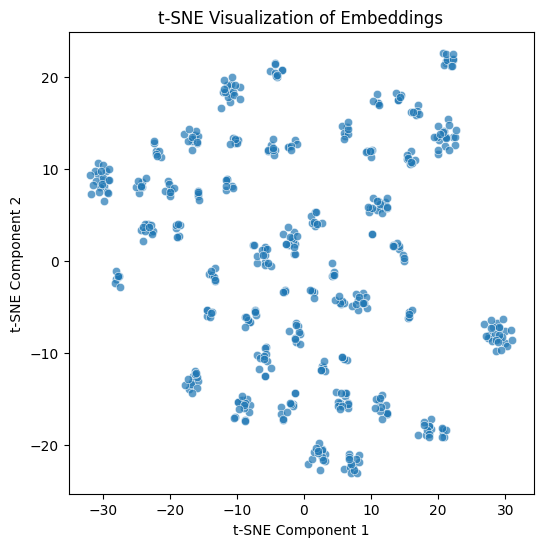

In [31]:
import matplotlib.pyplot as plt


# Plot the reduced embeddings
plt.figure(figsize=(6, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Embeddings')
plt.show()


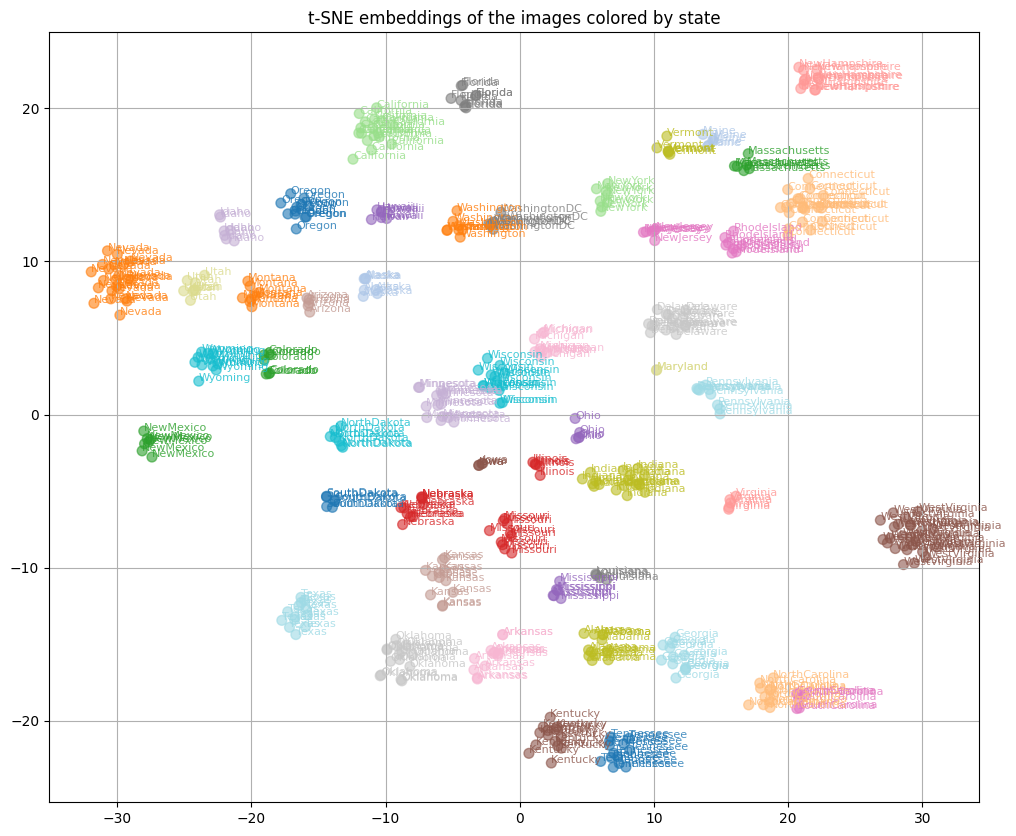

In [32]:
import numpy as np
import matplotlib.cm as cm

# Get unique states and their count
unique_states = list(set(image_labels))
num_unique_states = len(unique_states)

# Create a colormap with the desired number of colors
colors = cm.tab20(np.linspace(0, 1, num_unique_states))

# Create a dictionary to map each state to its corresponding color
state_to_color = {state: color for state, color in zip(unique_states, colors)}

# Map the labels to colors based on the image_labels list
label_colors = [state_to_color[state] for state in image_labels]


plt.figure(figsize=(12, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=label_colors, s=50, alpha=0.6)

# Create a legend
for state, color in state_to_color.items():
    plt.plot([0], [0], color=color, label=state)

# Annotate each point with its state label
for i, state in enumerate(image_labels):
    plt.annotate(state, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8,
                 color=state_to_color[state], alpha=0.8)

plt.title("t-SNE embeddings of the images colored by state")

plt.grid(True)
plt.show()


In [65]:
# Extract a single text_embedding and image_embedding from the first sample
sample_text_embedding = all_embeddings[0]['text_embedding']
sample_image_embedding = all_embeddings[0]['image_embedding']

# Check the shape or length of these embeddings
len_sample_text_embedding = len(sample_text_embedding)
len_sample_image_embedding = len(sample_image_embedding)

len_sample_text_embedding, len_sample_image_embedding

(1408, 1408)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# 1. Prepare the data
concatenated_embeddings = [sample['text_embedding'] + sample['image_embedding'] for sample in all_embeddings]
concatenated_embeddings_array = np.array(concatenated_embeddings)

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(concatenated_embeddings_array, image_labels, test_size=0.2, random_state=0, stratify=image_labels)

# 3. Train the GBM model
gbm = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=0)
gbm.fit(X_train, y_train)

# 4. Evaluate the model
y_pred = gbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


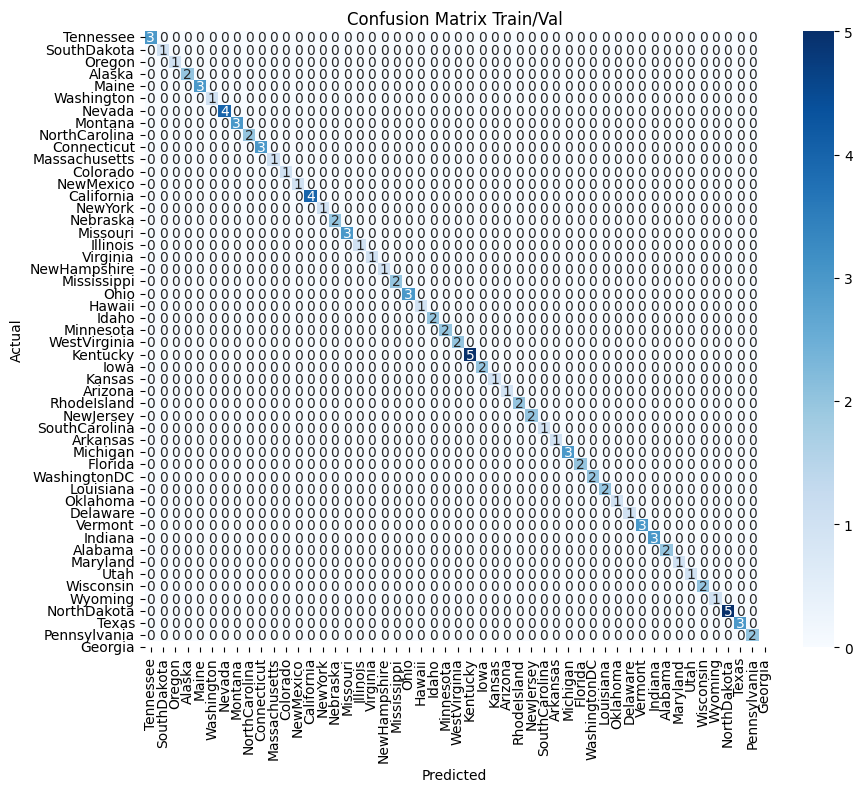

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_states, yticklabels=unique_states)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Train/Val')
plt.show()


In [36]:
# Create the two generators
#train_gen = data_generator(train_data, char_to_num, batch_size=batch_size)
#val_gen = data_generator(val_data, char_to_num, batch_size=batch_size)
# Test the generators
#train_inputs, train_outputs = next(train_gen)
#val_inputs, val_outputs = next(val_gen)

new_processed_images, processed_edgesT, new_image_labels = data_generator(data_list, char_to_num)
#processed_images, image_labels = data_generator(data_list, char_to_num)

#final_inputs = next(final)


In [37]:
import time

# Assuming you've already defined the functions and other necessary elements from previous steps...

# Step 1: Generate embeddings for the new validation samples
new_all_embeddings = []

# Define the batch size and total number of batches
batch_size = 120
num_batches = int(len(new_processed_images) / batch_size) + (len(new_processed_images) % batch_size != 0)

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(new_processed_images))

    for i in range(start_idx, end_idx):
        img_data = new_processed_images[i]
        state_label = new_image_labels[i]

        input_text = f'license plate from {state_label.lower()}'
        embedding = get_embedding_for_image_np(img_data, input_text, 'fifth-composite-395916')
        new_all_embeddings.append(embedding)

# Step 2: Concatenate embeddings
new_concatenated_embeddings = [sample['text_embedding'] + sample['image_embedding'] for sample in new_all_embeddings]
new_concatenated_embeddings_array = np.array(new_concatenated_embeddings)

# Step 3: Apply t-SNE to the concatenated embeddings array
new_reduced_embeddings = tsne.fit_transform(new_concatenated_embeddings_array)

# 'new_reduced_embeddings' now contains the t-SNE reduced embeddings for the new validation samples.


In [ ]:
from scipy.stats import ks_2samp

def compare_distributions(embedding1, embedding2):
    statistic, p_value = ks_2samp(embedding1, embedding2)
    if p_value > 0.05:
        print("The distributions are likely similar.")
        print('p = ', p_value)
    else:
        print("The distributions are likely different.")
        print('p = ', p_value)

# Comparing image embeddings as an example
compare_distributions(reduced_embeddings[:, 0], new_reduced_embeddings[:, 0])  # Compare first dimension as an example


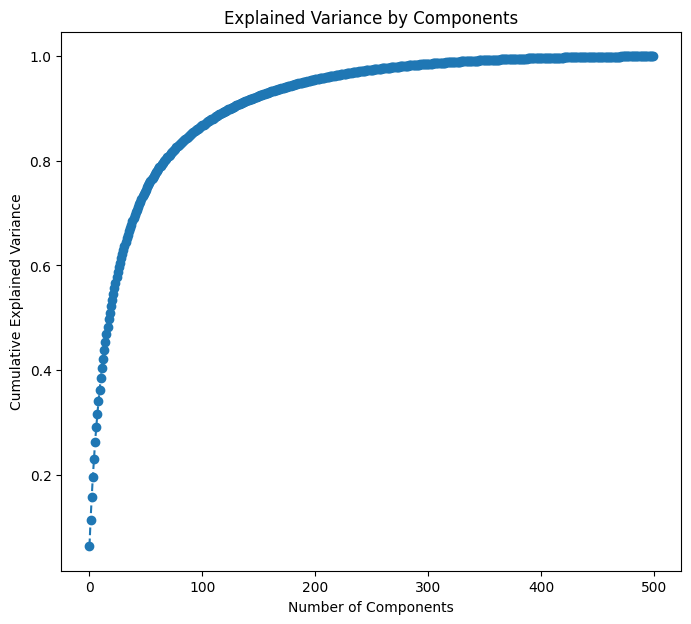

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Standardize the data
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(concatenated_embeddings_array)

# 2. Apply PCA
pca = PCA()
principalComponents = pca.fit_transform(scaled_embeddings)

# 3. Visualize the results
# Plotting the explained variance for each principal component
plt.figure(figsize=(8, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


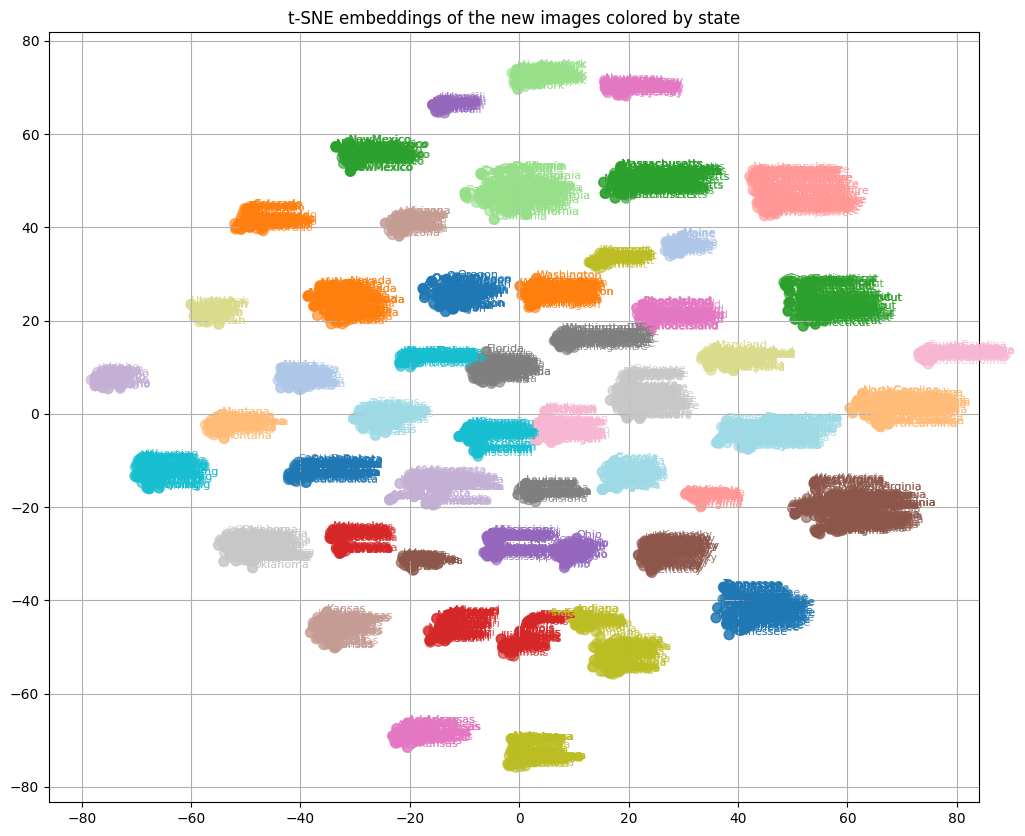

In [41]:
# Assuming new_image_labels is defined and contains the labels for the new validation samples
import matplotlib.cm as cm

# Get unique states and their count from the new data
new_unique_states = list(set(new_image_labels))
new_num_unique_states = len(new_unique_states)

# Create a colormap with the desired number of colors for the new data
new_colors = cm.tab20(np.linspace(0, 1, new_num_unique_states))

# Create a dictionary to map each state to its corresponding color for the new data
new_state_to_color = {state: color for state, color in zip(new_unique_states, new_colors)}

# Map the labels to colors based on the new_image_labels list
new_label_colors = [new_state_to_color[state] for state in new_image_labels]

# Visualization for the new data
plt.figure(figsize=(12, 10))
plt.scatter(new_reduced_embeddings[:, 0], new_reduced_embeddings[:, 1], c=new_label_colors, s=50, alpha=0.6)

# Create a legend for the new data
for state, color in new_state_to_color.items():
    plt.plot([0], [0], color=color, label=state)

# Annotate each point with its state label for the new data
for i, state in enumerate(new_image_labels):
    plt.annotate(state, (new_reduced_embeddings[i, 0], new_reduced_embeddings[i, 1]), fontsize=8,
                 color=new_state_to_color[state], alpha=0.8)

plt.title("t-SNE embeddings of the new images colored by state")

plt.grid(True)
plt.show()


Accuracy: 1.0


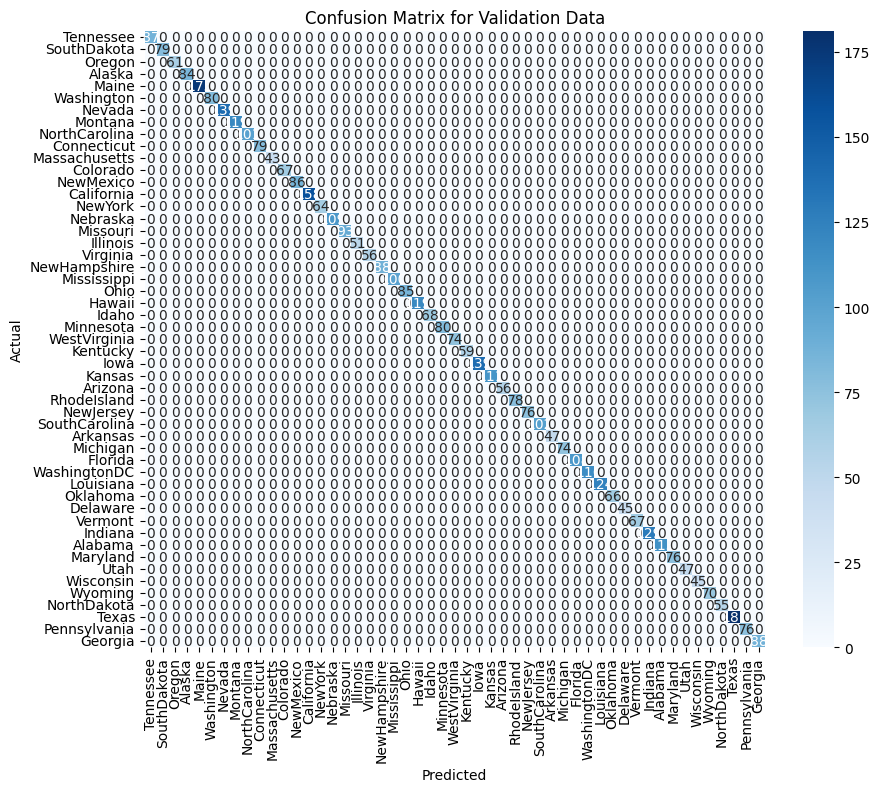

In [71]:
# Step 3: Predict labels for these reduced embeddings using the trained KNN classifier
new_y_pred = gbm.predict(new_concatenated_embeddings)

# Step 4: Generate and visualize the confusion matrix for the predicted labels
new_cm = confusion_matrix(new_image_labels, new_y_pred)
# Calculate the accuracy of the predictions
accuracy = accuracy_score(new_image_labels, new_y_pred)
print("Accuracy:", accuracy)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_states, yticklabels=unique_states)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Data')
plt.show()
